In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import holoviews as hv
from holoviews import opts
import hvplot.xarray

from pathlib import Path
from tqdm.notebook import tqdm

import networkx as nx
import geonetworkx as gnx

import warnings

warnings.filterwarnings('ignore')
hv.extension('bokeh')

We want to simulate a two reservoir system

In [20]:
g = 9.81 # m/s2

class Reservoir:
    def __init__(self, node, start_time='2000-01-01'):
        self.node = node

        self.reservoir_breadth = 100 # m
        self.reservoir_depth = 200   # m
        self.outlet_height = 0      # m
        self.outlet_diameter = 1  # m

        self.storage = 1e9            # m3
        self.inflow = 0             # m3/d
        self.storage_change = np.nan
        self.time = start_time if isinstance(start_time, pd.Timestamp) else pd.to_datetime(start_time)

        self.outlet_area = np.pi * (self.outlet_diameter / 2) ** 2

        # calculate derived properties
        self.water_height = self.storage / (self.reservoir_breadth * self.reservoir_depth)
        self.height_above_outlet = max([0, self.water_height - self.outlet_height]) # return height above outlet, or 0 if below outlet
        self.outlet_velocity = np.sqrt(2 * g * self.height_above_outlet)
        self.outlet_flow = self.outlet_area * self.outlet_velocity

        self.FIRST_RUN = 1

    def update(self, inflow, dt=1):
        """update for one time step

        Args:
            inflow (number): inflow rate (m3/d)
            dt (number): time step (1 day)
        """
        # prev_time = self.time
        # self.time += pd.Timedelta(seconds=dt)
        if self.FIRST_RUN:
            self.FIRST_RUN = 0  # if this is the first run, don't advance time
        else:
            self.time += pd.Timedelta(days=dt)
        
        self.inflow = inflow
        
        last_storage = self.storage
        self.storage += self.inflow * dt

        self.water_height = self.storage / (self.reservoir_breadth * self.reservoir_depth)
        self.height_above_outlet = max([0, self.water_height - self.outlet_height])

        self.outlet_velocity = np.sqrt(2 * g * self.height_above_outlet)
        self.outlet_flow = self.outlet_area * self.outlet_velocity

        self.storage -= self.outlet_flow * dt # update storage again after outflow is calcualted
        self.storage_change = self.storage - last_storage # calculate storage change
    
    def dumpds(self):
        return {
            'inflow': self.inflow,
            'outflow': self.outlet_flow,
            'storage': self.storage,
            'storage_change': self.storage_change,
            'water_height': self.water_height,
            'height_above_outlet': self.height_above_outlet,
        }

class ReservoirNetwork(nx.DiGraph):
    def __init__(self, network, start_time, *args, **kwargs):
        super().__init__(network, *args, **kwargs)
        # self.data = xr.open_dataset(data) if isinstance(data, str) \
        #     else data if isinstance(data, xr.Dataset) \
        #     else ValueError("Must provide either path of data file or as xr.Dataset")
        self.data = xr.Dataset(
            coords={
                'node': list(self.nodes),
                'time': pd.date_range(start_time, periods=1, freq='1D')
            }
        ) 
        self.network = {node: Reservoir(node) for node in self.nodes}
        self.time = start_time

        self.FIRST_RUN = 1

    def create_field(self, var, fill_value=0.0):
        """Create a new field if not already present in self.data"""
        if var not in self.data.variables:
            self.data[var] = xr.DataArray(
                data=np.full((len(self.nodes), len(self.data.time)), fill_value),
                dims=['node', 'time'],
                coords={'node': self.nodes, 'time': self.data.time}
            )

    def insert_new_time_step(self, time):
        """Insert a new time step and fill with np.nan for all variables"""
        if time not in self.data.time:
            data_vars = {}
            for var in self.data.variables:
                if var not in ['node', 'time']:
                    data_vars[var] = (['node', 'time'], np.full((len(self.nodes), 1), np.nan))
            new_timestep_ds = xr.Dataset(data_vars=data_vars, coords={'node': self.nodes, 'time': [self.time]})
            # self.data = xr.merge([self.data, new_timestep_ds])
            self.data = xr.concat([self.data, new_timestep_ds], dim='time')
        else:
            raise ValueError(f"Time {time} already exists in data.")

    def update(self, forcings, dt=1, algorithm='simple'):
        """Update the reservoir network for one time step.

        Args:
            dt (int, optional): time step in days. Defaults to 1 day.
            algorithm (str, optional): Defaults to 'simple'.
                - hydraulic - outflow from reservoir is simulated to estimate storage change. 
                - simple - requires storage change and unregulated inflow of previous node.
        """

        if self.FIRST_RUN:
            self.create_field('inflow', np.nan)
            self.create_field('outflow', np.nan)
            self.create_field('regulated_runoff', np.nan)
            self.create_field('natural_runoff', np.nan)
            self.create_field('theoretical_natural_runoff', np.nan)
            self.create_field('storage', np.nan)
            self.create_field('storage_change', np.nan)
            self.create_field('regulation', np.nan)
            self.FIRST_RUN = 0
        else:
            self.time += pd.Timedelta(days=dt)
            self.insert_new_time_step(self.time)
        
        # insert forcings into data
        for var in forcings.variables:
            if var not in ['node', 'time']:
                if var not in self.data.variables:
                    self.data[var] = forcings[var].sel(time=self.time)
                else:
                    self.data[var].loc[dict(time=self.time)] = forcings[var].sel(time=self.time)
        
        if algorithm == 'hydraulic':
            self._alg_hydraulic(forcings, dt)

        if algorithm == 'hydraulic_travel_time':
            self._alg_hydraulic_travel_time(forcings, dt)

        if algorithm == 'simple':
            self._alg_simple(forcings, dt)
        
        if algorithm == 'simple_travel_time':
            self._alg_simple_travel_time(forcings, dt)

    def _alg_simple(self, forcings, dt):
        for node in list(nx.topological_sort(self)):
            storage_change = float(forcings['storage_change'].sel(node=node, time=self.time))
            theoretical_natural_runoff = float(forcings['theoretical_natural_runoff'].sel(node=node, time=self.time))

            self.data['theoretical_natural_runoff'].loc[dict(node=node, time=self.time)] = theoretical_natural_runoff

            upstream_dams = list(self.predecessors(node))
            natural_runoff = theoretical_natural_runoff
            regulated_runoff = 0.0
            if len(upstream_dams) > 0:
                regulated_runoff = sum([float(self.data['outflow'].sel(node=n, time=self.time)) for n in upstream_dams])
                natural_runoff -= sum([float(self.data['theoretical_natural_runoff'].sel(node=n, time=self.time)) for n in upstream_dams])

            inflow = max([0, float(natural_runoff + regulated_runoff)])
            outflow = max([0, inflow - storage_change])
            regulation = theoretical_natural_runoff - inflow

            self.data['inflow'].loc[dict(node=node, time=self.time)] = inflow
            self.data['outflow'].loc[dict(node=node, time=self.time)] = outflow
            self.data['regulation'].loc[dict(node=node, time=self.time)] = regulation
            self.data['natural_runoff'].loc[dict(node=node, time=self.time)] = natural_runoff
            self.data['regulated_runoff'].loc[dict(node=node, time=self.time)] = regulated_runoff

    def _alg_simple_travel_time(self, forcings, dt):
        for node in list(nx.topological_sort(self)):
            storage_change = float(forcings['storage_change'].sel(node=node, time=self.time))
            unregulated_inflow = float(forcings['unregulated_inflow'].sel(node=node, time=self.time))

            upstreams = list(self.predecessors(node))
            upstream_outflow = 0.0
            upstream_unregulated_inflow = 0.0
            if len(upstreams) > 0:
                time_lags = [self.time - pd.to_timedelta(round(self.get_edge_data(upstream, node)['travel_time']), 'd') for upstream in upstreams]
                upstream_outflow = sum([float(self.data['outflow'].sel(node=n, time=t)) for n, t in zip(upstreams, time_lags)])
                upstream_unregulated_inflow = sum([float(self.data['unregulated_inflow'].sel(node=n, time=t)) for n, t in zip(upstreams, time_lags)])
            
            regulated_inflow = max([0, float(unregulated_inflow - upstream_unregulated_inflow + upstream_outflow)])
            outflow = max([0, regulated_inflow - storage_change])

            self.data['regulated_inflow'].loc[dict(node=node, time=self.time)] = regulated_inflow
            self.data['outflow'].loc[dict(node=node, time=self.time)] = outflow

    def _alg_hydraulic(self, forcings, dt):
        for node in list(nx.topological_sort(self)):
            # get reservoir object
            res = self.network[node]
            # get inflow for this node
            natural_runoff = (forcings['natural_runoff'].sel(node=node, time=slice(self.time - pd.Timedelta(days=dt), self.time)).mean() * dt).data # m3

            # if there are upstream nodes, the inflow 
            regulated_runoff = 0
            theoretical_natural_runoff = natural_runoff.copy()
            upstreams = list(self.predecessors(node))
            if len(upstreams) > 0:
                # sum the outflow from upstream nodes to the inflow of this node
                regulated_runoff += sum([self.data['outflow'].sel(node=n, time=self.time) for n in upstreams]).data
                theoretical_natural_runoff += sum([self.data['theoretical_natural_runoff'].sel(node=n, time=self.time) for n in upstreams]).data
            
            inflow = natural_runoff + regulated_runoff
            res.update(inflow, 1) # run one time-step of the reservoir model

            res_data = res.dumpds()

            self.data['inflow'].loc[dict(node=node, time=self.time)] = res_data['inflow']
            self.data['outflow'].loc[dict(node=node, time=self.time)] = res_data['outflow']
            self.data['regulation'].loc[dict(node=node, time=self.time)] = theoretical_natural_runoff - res_data['inflow']
            self.data['storage_change'].loc[dict(node=node, time=self.time)] = res_data['storage_change']
            self.data['storage'].loc[dict(node=node, time=self.time)] = res_data['storage']
            self.data['regulated_runoff'].loc[dict(node=node, time=self.time)] = regulated_runoff
            self.data['theoretical_natural_runoff'].loc[dict(node=node, time=self.time)] = theoretical_natural_runoff

    def _alg_hydraulic_travel_time(self, forcings, dt):
        for node in list(nx.topological_sort(self)):
            # get reservoir object
            res = self.network[node]
            # get inflow for this node
            inflow = (forcings['inflow'].sel(node=node, time=slice(self.time - pd.Timedelta(days=dt), self.time)).mean() * dt).data # m3

            # if there are upstream nodes, the inflow 
            regulated_inflow = 0
            upstreams = list(self.predecessors(node))
            if len(upstreams) > 0:
                # sum the outflow from upstream nodes to the inflow of this node
                time_lags = [G.get_edge_data(upstream, node)['travel_time'] for upstream in upstreams]
                #### NOTE: method='nearest' is used as of now to get the nearest available upstream outflow value to the self.time-time_lag time.
                ####       this must be handled later, either by interpolating, or using np.nan for the first few time steps.
                regulated_inflow += sum([self.data['outflow'].sel(node=n, time=self.time-pd.Timedelta(lag, 'D'), method='nearest') for n, lag in zip(upstreams, time_lags)]).data
                inflow += regulated_inflow

            # update data
            self.data['inflow'].loc[dict(node=node, time=self.time)] = inflow
            self.data['regulated_inflow'].loc[dict(node=node, time=self.time)] = regulated_inflow
            self.data['unregulated_inflow'].loc[dict(node=node, time=self.time)] = inflow - regulated_inflow

            res.update(inflow, 1)
            # self.data.update(res.dumpds())
            res_data = res.dumpds()
            self.data = xr.merge([self.data, res_data])  # compat='override' will ensure that any existing variables (such as inflow, which was first initialized according to forcings) will be overwritten by the model outputs, which also includes inflow from upstream nodes.

In [21]:
# reservoir_network.data['unregulated_inflow'].sel(node=2).hvplot()

# Run model using constant inflow of 1000 m3/d

In [29]:
## RUN MODEL
start_time = pd.to_datetime('2000-01-01')
time_steps = 1e3

# define network
G = nx.DiGraph()
G.add_nodes_from([
    (1, {"name": "A"}),
    (2, {"name": "B"}),
])
G.add_edge(1, 2)

natural_runoff_data = xr.DataArray(
    data=np.array([[1000., 0.] for _ in np.arange(time_steps)]),
    dims=['time', 'node'],
    coords={'node': [1, 2], 'time': pd.date_range(start_time, periods=time_steps, freq='1D')}
)
forcings = xr.Dataset(
    data_vars={
        'natural_runoff': natural_runoff_data,
    }
)
reservoir_network = ReservoirNetwork(G, start_time)

for timestep in tqdm(np.arange(time_steps)):
    reservoir_network.update(forcings, 1, 'hydraulic')


reservoir_network.data

  0%|          | 0/1000 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:                     (node: 2, time: 1000)
Coordinates:
  * node                        (node) int64 1 2
  * time                        (time) datetime64[ns] 2000-01-01 ... 2002-09-26
Data variables:
    inflow                      (node, time) float64 1e+03 1e+03 ... 778.0 778.0
    outflow                     (node, time) float64 777.9 777.9 ... 777.9 777.9
    regulated_runoff            (node, time) float64 0.0 0.0 0.0 ... 778.0 778.0
    natural_runoff              (node, time) float64 1e+03 1e+03 ... 0.0 0.0
    theoretical_natural_runoff  (node, time) float64 1e+03 1e+03 ... 1e+03 1e+03
    storage                     (node, time) float64 1e+09 1e+09 ... 1e+09 1e+09
    storage_change              (node, time) float64 222.1 222.1 ... 0.08635
    regulation                  (node, time) float64 0.0 0.0 0.0 ... 222.0 222.0

{1: Text(0.8719034503370965, -0.9999999999999996, '1'),
 2: Text(-0.8719034503370965, 1.0, '2')}

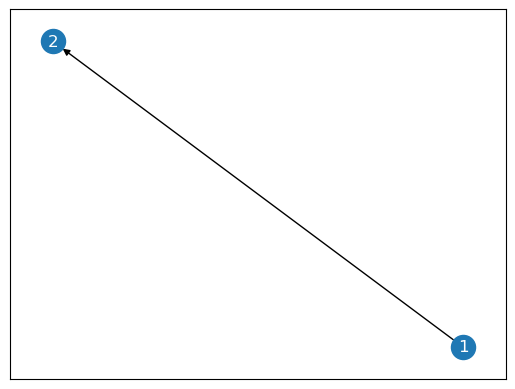

In [30]:
# plot reservoir network

pos = nx.drawing.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
# nx.draw_networkx_labels(G, pos, labels={node:G.nodes[node]['name'] for node in G.nodes},font_color='red')
nx.draw_networkx_labels(G, pos,font_color='white')

In [31]:
results_hvds = hv.Dataset(reservoir_network.data)

inflow_plot = results_hvds.to(hv.Curve, 'time', 'inflow', 'node').layout('node').cols(1).opts(title='inflow')

# create stacked area plots
regulated_area_plot = results_hvds.to(hv.Area, 'time', 'regulated_runoff', 'node', label='regulated flow').opts(alpha=0.2).layout('node').cols(1).opts(title='regulated inflow')
unregulated_area_plot = results_hvds.to(hv.Area, 'time', 'natural_runoff', 'node', label='unregulated flow').opts(alpha=0.2).layout('node').cols(1).opts(title='unregulated inflow')
overlay = (regulated_area_plot * unregulated_area_plot)
stacked = []
for inner_overlay, inner_inflow, node in zip(overlay, inflow_plot, reservoir_network.data['node'].data):
    stacked.append((hv.Area.stack(inner_overlay)*inner_inflow).opts(ylabel='inflow (m3/d)', title=f'Node {node}'))
inflow_distribution = hv.Layout(stacked).cols(1)

inflow_distribution

:Layout
   .Overlay.I  :Overlay
      .Area.Regulated_flow   :Area   [time]   (regulated_runoff,Baseline)
      .Area.Unregulated_flow :Area   [time]   (natural_runoff,Baseline)
      .Curve.I               :Curve   [time]   (inflow)
   .Overlay.II :Overlay
      .Area.Regulated_flow   :Area   [time]   (regulated_runoff,Baseline)
      .Area.Unregulated_flow :Area   [time]   (natural_runoff,Baseline)
      .Curve.I               :Curve   [time]   (inflow)

In [32]:
inflow_curve = results_hvds.to(hv.Curve, 'time', 'inflow', 'node').layout('node').cols(1).opts(title='inflow')
outflow_curve = results_hvds.to(hv.Curve, 'time', 'outflow', 'node').layout('node').cols(1).opts(title='outflow')
storage_curve = results_hvds.to(hv.Curve, 'time', 'storage', 'node').layout('node').cols(1).opts(title='storage')

(inflow_curve + outflow_curve + storage_curve).opts(opts.Curve(axiswise=True, tools=['hover']))

:Layout
   .NdLayout.I   :NdLayout   [node]
      :Curve   [time]   (inflow)
   .NdLayout.II  :NdLayout   [node]
      :Curve   [time]   (outflow)
   .NdLayout.III :NdLayout   [node]
      :Curve   [time]   (storage)

## We now want to use the `simple` algorithm to calculate the regulated inflow to the downstream reservoir.

In [33]:
## RUN MODEL
start_time = pd.to_datetime('2000-01-01')
time_steps = 1e3

# define network
G = nx.DiGraph()
G.add_nodes_from([
    (1, {"name": "A"}),
    (2, {"name": "B"}),
])
G.add_edge(1, 2)

sim_data = xr.open_dataset('/water2/pdas47/2023_01_24-river-regulation/data-two-reservoir/simulated/constant_inflow.nc')
forcings = xr.Dataset(
    data_vars={
        'storage_change': sim_data['storage_change'],
        'theoretical_natural_runoff': sim_data['theoretical_natural_runoff']
    }
)

reservoir_network = ReservoirNetwork(G, start_time)

for timestep in tqdm(np.arange(time_steps)):
    reservoir_network.update(forcings, 1, 'simple')

reservoir_network.data

  0%|          | 0/1000 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:                     (node: 2, time: 1000)
Coordinates:
  * node                        (node) int64 1 2
  * time                        (time) datetime64[ns] 2000-01-01 ... 2002-09-26
Data variables:
    inflow                      (node, time) float64 1e+03 1e+03 ... 778.0 778.0
    outflow                     (node, time) float64 777.9 777.9 ... 777.9 777.9
    regulated_runoff            (node, time) float64 0.0 0.0 0.0 ... 778.0 778.0
    natural_runoff              (node, time) float64 1e+03 1e+03 ... 0.0 0.0
    theoretical_natural_runoff  (node, time) float64 1e+03 1e+03 ... 1e+03 1e+03
    storage                     (node, time) float64 nan nan nan ... nan nan nan
    storage_change              (node, time) float64 222.1 222.1 ... 0.08635
    regulation                  (node, time) float64 0.0 0.0 0.0 ... 222.0 222.0

In [34]:
# save reservoir.data
# savefp = "/water2/pdas47/2023_01_24-river-regulation/data-two-reservoir/simulated/constant_inflow.nc"
# reservoir_network.data.to_netcdf(savefp)

In [35]:
simulated_hvds = hv.Dataset(reservoir_network.data)

inflow_plot = simulated_hvds.to(hv.Curve, 'time', 'inflow', 'node').layout('node').cols(1).opts(title='inflow')

# create stacked area plots
regulated_area_plot = simulated_hvds.to(hv.Area, 'time', 'regulated_runoff', 'node', label='regulated flow').opts(alpha=0.2).layout('node').cols(1).opts(title='regulated inflow')
unregulated_area_plot = simulated_hvds.to(hv.Area, 'time', 'natural_runoff', 'node', label='unregulated flow').opts(alpha=0.2).layout('node').cols(1).opts(title='unregulated inflow')
overlay = (regulated_area_plot * unregulated_area_plot)

stacked = []
for inner_overlay, inner_inflow, node in zip(overlay, inflow_plot, reservoir_network.data['node'].data):
    stacked.append((hv.Area.stack(inner_overlay)*inner_inflow).opts(ylabel='inflow (m3/d)', title=f'Node {node}'))
inflow_distribution = hv.Layout(stacked).cols(1)

inflow_distribution

:Layout
   .Overlay.I  :Overlay
      .Area.Regulated_flow   :Area   [time]   (regulated_runoff,Baseline)
      .Area.Unregulated_flow :Area   [time]   (natural_runoff,Baseline)
      .Curve.I               :Curve   [time]   (inflow)
   .Overlay.II :Overlay
      .Area.Regulated_flow   :Area   [time]   (regulated_runoff,Baseline)
      .Area.Unregulated_flow :Area   [time]   (natural_runoff,Baseline)
      .Curve.I               :Curve   [time]   (inflow)

compare metrics

In [42]:
inflow_curve = results_hvds.to(hv.Curve, 'time', 'inflow', 'node', label='inflow').layout('node').cols(1).opts(title='inflow') * simulated_hvds.to(hv.Curve, 'time', 'inflow', 'node', label='simulated_inflow').layout('node').cols(1).opts(title='Simulated inflow')
outflow_curve = results_hvds.to(hv.Curve, 'time', 'outflow', 'node', label='outflow').layout('node').cols(1).opts(title='outflow') * simulated_hvds.to(hv.Curve, 'time', 'outflow', 'node', label='simulated_outflow').layout('node').cols(1).opts(title='Simulated outflow')
storage_curve = results_hvds.to(hv.Curve, 'time', 'storage', 'node', label='storage').layout('node').cols(1).opts(title='storage') * simulated_hvds.to(hv.Curve, 'time', 'storage', 'node', label='simulated_storage').layout('node').cols(1).opts(title='Simulated storage')

(inflow_curve + outflow_curve + storage_curve).opts(opts.Curve(axiswise=True, tools=['hover']))


:Layout
   .NdLayout.Inflow  :NdLayout   [node]
      :Overlay
         .Curve.Inflow           :Curve   [time]   (inflow)
         .Curve.Simulated_inflow :Curve   [time]   (inflow)
   .NdLayout.Outflow :NdLayout   [node]
      :Overlay
         .Curve.Outflow           :Curve   [time]   (outflow)
         .Curve.Simulated_outflow :Curve   [time]   (outflow)
   .NdLayout.Storage :NdLayout   [node]
      :Overlay
         .Curve.Storage           :Curve   [time]   (storage)
         .Curve.Simulated_storage :Curve   [time]   (storage)

In [37]:
from sklearn.metrics import r2_score

# r2_score(results_hvds['inflow'], simulated_hvds['inflow'])

1.0

# Now let's try with a pulse of 1e4 m3/d, for 30 days, otherwise constant inflow of 100 m3/d

In [7]:
# define network
G = nx.DiGraph()
G.add_nodes_from([
    (1, {"name": "A"}),
    (2, {"name": "B"}),
])
G.add_edge(1, 2)

start_time = pd.to_datetime('2000-01-01')
time_steps = 1e3

inflow_data = xr.DataArray(
    data=np.array([[100., 100.] for _ in np.arange(time_steps)]),
    dims=['time', 'node'],
    coords={'node': [1, 2], 'time': pd.date_range(start_time, periods=time_steps, freq='1D')}
)
inflow_data.loc[dict(time=slice('2000-05-01', '2000-05-30'), node=1)] = 1e4
inflow_data.loc[dict(time=slice('2000-10-01', '2000-10-30'), node=1)] = 1e4
inflow_data.loc[dict(time=slice('2000-03-01', '2000-03-30'), node=1)] = 1e4

forcings = xr.Dataset(
    data_vars={
        'inflow': inflow_data,
    }
)

data = xr.Dataset(
    coords={
        'node': [1, 2],
        'time': pd.date_range(start_time, periods=1, freq='1D')
    }
)

In [8]:
reservoir_network = ReservoirNetwork(G, start_time)

for timestep in tqdm(np.arange(time_steps)):
    reservoir_network.update(forcings, 1, 'hydraulic')

reservoir_network.data

  0%|          | 0/1000 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:              (node: 2, time: 1000)
Coordinates:
  * node                 (node) int64 1 2
  * time                 (time) datetime64[ns] 2000-01-01 ... 2002-09-26
Data variables:
    inflow               (node, time) float64 100.0 100.0 100.0 ... 878.0 878.0
    outflow              (node, time) float64 777.9 777.9 777.9 ... 777.9 777.9
    regulated_inflow     (node, time) float64 0.0 0.0 0.0 ... 778.0 778.0 778.0
    unregulated_inflow   (node, time) float64 100.0 100.0 100.0 ... 100.0 100.0
    storage              (node, time) float64 1e+09 1e+09 1e+09 ... 1e+09 1e+09
    storage_change       (node, time) float64 -677.9 -677.9 ... 100.0 100.0
    water_height         (node, time) float64 5e+04 5e+04 ... 5.001e+04
    height_above_outlet  (node, time) float64 5e+04 5e+04 ... 5.001e+04
    outlet_velocity      (node, time) float64 990.5 990.5 990.5 ... 990.5 990.5

In [9]:
results_hvds = hv.Dataset(reservoir_network.data)

inflow_plot = results_hvds.to(hv.Curve, 'time', 'inflow', 'node').layout('node').cols(1).opts(title='inflow')

# create stacked area plots
regulated_area_plot = results_hvds.to(hv.Area, 'time', 'regulated_inflow', 'node', label='regulated flow').opts(alpha=0.2).layout('node').cols(1).opts(title='regulated inflow')
unregulated_area_plot = results_hvds.to(hv.Area, 'time', 'unregulated_inflow', 'node', label='unregulated flow').opts(alpha=0.2).layout('node').cols(1).opts(title='unregulated inflow')
overlay = (regulated_area_plot * unregulated_area_plot)
stacked = []
for inner_overlay, inner_inflow, node in zip(overlay, inflow_plot, reservoir_network.data['node'].data):
    stacked.append((hv.Area.stack(inner_overlay)*inner_inflow).opts(ylabel='inflow (m3/d)', title=f'Node {node}'))
inflow_distribution = hv.Layout(stacked).cols(1)

inflow_distribution

:Layout
   .Overlay.I  :Overlay
      .Area.Regulated_flow   :Area   [time]   (regulated_inflow,Baseline)
      .Area.Unregulated_flow :Area   [time]   (unregulated_inflow,Baseline)
      .Curve.I               :Curve   [time]   (inflow)
   .Overlay.II :Overlay
      .Area.Regulated_flow   :Area   [time]   (regulated_inflow,Baseline)
      .Area.Unregulated_flow :Area   [time]   (unregulated_inflow,Baseline)
      .Curve.I               :Curve   [time]   (inflow)

In [10]:
inflow_curve = results_hvds.to(hv.Curve, 'time', 'inflow', 'node').layout('node').cols(1).opts(title='inflow')
outflow_curve = results_hvds.to(hv.Curve, 'time', 'outflow', 'node').layout('node').cols(1).opts(title='outflow')
storage_curve = results_hvds.to(hv.Curve, 'time', 'storage', 'node').layout('node').cols(1).opts(title='storage')

(inflow_curve + outflow_curve + storage_curve).opts(opts.Curve(axiswise=True, tools=['hover']))

:Layout
   .NdLayout.I   :NdLayout   [node]
      :Curve   [time]   (inflow)
   .NdLayout.II  :NdLayout   [node]
      :Curve   [time]   (outflow)
   .NdLayout.III :NdLayout   [node]
      :Curve   [time]   (storage)

In [17]:
case = 'pulse'
base_dir = Path('../../data-two-reservoir/simulated/')
save_fp = base_dir / f'{case}.nc'
if save_fp.exists():
    raise ValueError(f"File {save_fp} already exists. Please delete or rename the file.")
else:
    reservoir_network.data.to_netcdf(save_fp)

# Constant flow, but with travel time of 2 days

In [22]:
# define network
G = nx.DiGraph()
G.add_nodes_from([
    (1, {"name": "A"}),
    (2, {"name": "B"}),
])
G.add_edge(1, 2, travel_time=2)

start_time = pd.to_datetime('2000-01-01')
time_steps = 1e3

inflow_data = xr.DataArray(
    data=np.array([[1000., 0.] for _ in np.arange(time_steps)]),
    dims=['time', 'node'],
    coords={'node': [1, 2], 'time': pd.date_range(start_time, periods=time_steps, freq='1D')}
)

forcings = xr.Dataset(
    data_vars={
        'inflow': inflow_data,
    }
)

data = xr.Dataset(
    coords={
        'node': [1, 2],
        'time': pd.date_range(start_time, periods=1, freq='1D')
    }
)

In [23]:
reservoir_network = ReservoirNetwork(G, start_time)

for timestep in tqdm(np.arange(time_steps)):
    reservoir_network.update(forcings, 1, 'hydraulic_travel_time')

reservoir_network.data

  0%|          | 0/1000 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:              (node: 2, time: 1000)
Coordinates:
  * node                 (node) int64 1 2
  * time                 (time) datetime64[ns] 2000-01-01 ... 2002-09-26
Data variables:
    inflow               (node, time) float64 1e+03 1e+03 1e+03 ... 778.0 778.0
    outflow              (node, time) float64 777.9 777.9 777.9 ... 777.9 777.9
    regulated_inflow     (node, time) float64 0.0 0.0 0.0 ... 778.0 778.0 778.0
    unregulated_inflow   (node, time) float64 1e+03 1e+03 1e+03 ... 0.0 0.0 0.0
    storage              (node, time) float64 1e+09 1e+09 1e+09 ... 1e+09 1e+09
    storage_change       (node, time) float64 222.1 222.1 ... 0.08609 0.08617
    water_height         (node, time) float64 5e+04 5e+04 5e+04 ... 5e+04 5e+04
    height_above_outlet  (node, time) float64 5e+04 5e+04 5e+04 ... 5e+04 5e+04
    outlet_velocity      (node, time) float64 990.5 990.5 990.5 ... 990.5 990.5

In [24]:
results_hvds = hv.Dataset(reservoir_network.data)

inflow_plot = results_hvds.to(hv.Curve, 'time', 'inflow', 'node').layout('node').cols(1).opts(title='inflow')

# create stacked area plots
regulated_area_plot = results_hvds.to(hv.Area, 'time', 'regulated_inflow', 'node', label='regulated flow').opts(alpha=0.2).layout('node').cols(1).opts(title='regulated inflow')
unregulated_area_plot = results_hvds.to(hv.Area, 'time', 'unregulated_inflow', 'node', label='unregulated flow').opts(alpha=0.2).layout('node').cols(1).opts(title='unregulated inflow')
overlay = (regulated_area_plot * unregulated_area_plot)
stacked = []
for inner_overlay, inner_inflow, node in zip(overlay, inflow_plot, reservoir_network.data['node'].data):
    stacked.append((hv.Area.stack(inner_overlay)*inner_inflow).opts(ylabel='inflow (m3/d)', title=f'Node {node}'))
inflow_distribution = hv.Layout(stacked).cols(1)

inflow_distribution

:Layout
   .Overlay.I  :Overlay
      .Area.Regulated_flow   :Area   [time]   (regulated_inflow,Baseline)
      .Area.Unregulated_flow :Area   [time]   (unregulated_inflow,Baseline)
      .Curve.I               :Curve   [time]   (inflow)
   .Overlay.II :Overlay
      .Area.Regulated_flow   :Area   [time]   (regulated_inflow,Baseline)
      .Area.Unregulated_flow :Area   [time]   (unregulated_inflow,Baseline)
      .Curve.I               :Curve   [time]   (inflow)

In [25]:
inflow_curve = results_hvds.to(hv.Curve, 'time', 'inflow', 'node').layout('node').cols(1).opts(title='inflow')
outflow_curve = results_hvds.to(hv.Curve, 'time', 'outflow', 'node').layout('node').cols(1).opts(title='outflow')
storage_curve = results_hvds.to(hv.Curve, 'time', 'storage', 'node').layout('node').cols(1).opts(title='storage')

(inflow_curve + outflow_curve + storage_curve).opts(opts.Curve(axiswise=True, tools=['hover']))

:Layout
   .NdLayout.I   :NdLayout   [node]
      :Curve   [time]   (inflow)
   .NdLayout.II  :NdLayout   [node]
      :Curve   [time]   (outflow)
   .NdLayout.III :NdLayout   [node]
      :Curve   [time]   (storage)

**Next steps**
- use the generated results to drive the 'simple' algorithm to see if the unregulated inflow is being calculated correctly.
     - if not, what tweaks are needed?

- check the mass balance of the fluxes.